# WELCOME TO THE ORCA NOTEBOOK
## *Moorena bouillonii* Chemogeography Expansion

This branch of ORCA was used for the 4th Chapter of my PhD Dissertation- *Moorena bouillonii* Chemogeography: Distributional Patterns of Compounds and Compound Families at Multiple Spatial Scales.
Please excuse the digital dust - the whirlwind of finishing my PhD has not yet allowed for me to get everything cleaned up yet. Feel free to check out the code, but if you would like a more user-friendly experience, please see the master branch!
_______________________________________________________________________________________________________________________________

Pipeline for the **O**bjective **R**elational **C**omparative **A**nalyses of mass spectral data, along with other data sources. All you need is a directory of mzXML files or a features vs samples bucket table to get started!

To run cells of code, select cell and then press **Shift + Enter**. The first cell loads-in python modules necessary for the rest of the code to function

In some of the cells below, the user will need to input information, such as setting paths, setting parameters, etc. In these cases, the user will see a cell with variables to be set at the top, followed by a line of '###', below which the rest of the code can be seen. Please set all applicable variables above the '###' line. Tinkering with the code below the '###' line is highly encouraged, as that is precisely why we chose to make it available as a Jupyter Notebook, however it could result in a 'breaking' of ORCA. If that appears to be the case, simply clone again from GitHub to get back to working code.

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from pyteomics import mzxml, auxiliary
import glob
from scipy.spatial.distance import pdist, squareform, cosine
import itertools
import networkx as nx
from statistics import mean
import matplotlib 
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, set_link_color_palette
from collections import Counter
import sklearn.feature_selection
from scipy.stats import ttest_ind
import seaborn as sns; sns.set()


np.set_printoptions(precision=4, edgeitems=5, linewidth=100, suppress=True, threshold=10000)


# MS1 Feature Processing

This cell contains the first variable that you need to assign, if you are using ORCA to do MS1 feature processing - the path to the folder (directory) that contains your samples. If this notebook is in the same folder as your samples, the path should be './'. After you set the path, run the cell (**Shift + Enter**) and it should display a list of your mzXML sample files. If your files are not displayed, your path may be wrong.

Note: If you already have a features vs samples bucket table, and are not trying to use ORCA for MS1 Feature Processing, please proceed to the section in the notebook titled **Analyses**

In [26]:
path_to_sample_directory = '../Guam_Mb_comps/' #last character should always be '/'

#######################################################################################################

#Load files from the indicated directory with .mzXML extension
fns = glob.glob(path_to_sample_directory +'*.mzXML')
fns.sort()
peak_list = []
peak_range_low = []
peak_range_high = []
rt_list = []
rt_range_low = []
rt_range_high = []
rrt_list = []
rrt_range_low = []
rrt_range_high = []
integ = []
sample = []
fns

['../Guam_Mb_comps/GS_1A.mzXML',
 '../Guam_Mb_comps/GS_1B.mzXML',
 '../Guam_Mb_comps/GS_1C.mzXML',
 '../Guam_Mb_comps/GS_1D.mzXML',
 '../Guam_Mb_comps/GS_1E.mzXML',
 '../Guam_Mb_comps/GS_2A.mzXML',
 '../Guam_Mb_comps/GS_2B.mzXML',
 '../Guam_Mb_comps/GS_2C.mzXML',
 '../Guam_Mb_comps/GS_2D.mzXML',
 '../Guam_Mb_comps/GS_2E.mzXML',
 '../Guam_Mb_comps/GS_3A.mzXML',
 '../Guam_Mb_comps/GS_3B.mzXML',
 '../Guam_Mb_comps/GS_3C.mzXML',
 '../Guam_Mb_comps/GS_3D.mzXML',
 '../Guam_Mb_comps/GS_3E.mzXML',
 '../Guam_Mb_comps/GS_4A.mzXML',
 '../Guam_Mb_comps/GS_4B.mzXML',
 '../Guam_Mb_comps/GS_4C.mzXML',
 '../Guam_Mb_comps/GS_4D.mzXML',
 '../Guam_Mb_comps/GS_4E.mzXML']

### Load metadata for mzXML files
This cell contains another variable for you to assign - the path to a metadata file, that has information about your samples. At minimum, this file needs a column titled 'filename' that includes the filename (including the .mzXML extension) for each of your samples. If this notebook is in the same folder as your metadata file, the path should be './*name-of-metadata-file.csv*'. After you set the path, run the cell and it should display your metadata file as a table, with two additional columns added that include modified versions of the filenames - these are important for mapping metadata later on in the analyses.

In [32]:
path_to_metadata = '../Guam_Mb_comps/metadata.csv'

##############################################################################################################
#load in metadata file, mapping file names to other information

md = pd.read_csv(path_to_metadata)
md['filename_stripped'] = [f.split('.mzXML')[0] for f in md['filename']]
md['filename_path'] = [path_to_sample_directory + f for f in md['filename']]
md

,filename,cyano,shrimp,name,rep,filename_stripped,filename_path
0,GS_1A.mzXML,ns,ns,non-shrimp cyano A,A,GS_1A,../Guam_Mb_comps/GS_1A.mzXML
1,GS_1B.mzXML,ns,ns,non-shrimp cyano B,B,GS_1B,../Guam_Mb_comps/GS_1B.mzXML
2,GS_1C.mzXML,ns,ns,non-shrimp cyano C,C,GS_1C,../Guam_Mb_comps/GS_1C.mzXML
3,GS_1D.mzXML,ns,ns,non-shrimp cyano D,D,GS_1D,../Guam_Mb_comps/GS_1D.mzXML
4,GS_1E.mzXML,ns,ns,non-shrimp cyano E,E,GS_1E,../Guam_Mb_comps/GS_1E.mzXML
5,GS_2A.mzXML,ns,s,non-shrimp cyano + shrimp A,A,GS_2A,../Guam_Mb_comps/GS_2A.mzXML
6,GS_2B.mzXML,ns,s,non-shrimp cyano + shrimp B,B,GS_2B,../Guam_Mb_comps/GS_2B.mzXML
7,GS_2C.mzXML,ns,s,non-shrimp cyano + shrimp C,C,GS_2C,../Guam_Mb_comps/GS_2C.mzXML
8,GS_2D.mzXML,ns,s,non-shrimp cyano + shrimp D,D,GS_2D,../Guam_Mb_comps/GS_2D.mzXML
9,GS_2E.mzXML,ns,s,non-shrimp cyano + shrimp E,E,GS_2E,../Guam_Mb_comps/GS_2E.mzXML


### Custom retention time function
The original intent behind the design of ORCA was to be able to perform MS1 analyses on heterogeneous datasets (e.g. comparing data files acquired at different time points, under different chromatographic conditions, etc). In particular, we were faced with comparing current samples and legacy samples that had been run on similar but not the same chromatgraphic method (namely, a 2-min increase in run length to compensate for a XX decrease in flow-rate). This meant that using retention time as a second dimension (along with m/z) to charcaterize MS1 features did not allow of the proper consolidation of MS1 features across different samples. We were able to overcome this by instead using relative retention, along with applying an appropriate relative retention time tolerance window as determined through manual validation.

Datasets that are more chromatographically hterogeneous than ours will likely require more complex functions applied to retention time in order for it to remain a reasonable and reliable second dimension by which MS1 features can be consolidated. We provide the opportunity to apply custom retention time functions in the cell below. Some ideas are: XX

As is always the case when setting parameters or applying custom functions in tools, it is the user's responsibility to manually validate that appropriate parameters and functions have been applied. What this specifically means is checking that features known to be the same across different samples are in fact being considered the same in the resultant features vs samples bucket table. If this is not the case, please change the parameters/functions. The best guidance on selecting appropriate parameters and functions comes from studying and identifying the nuances in your dataset!

In [ ]:
#Custom retention time function

def custom_rt(rt, total_run_time):
    return rt/total_run_time

    

### Set paramters for MS1 feature picking

Here are descriptions and recommendations for the different parameters to be set

**bin_width**: The first step in generating feature lists for each sample is to divide the range of m/z values to be considered into bins, sorting features into these bins based on m/z, and then grouping peaks within each bin based on those peaks occurring in consecutive MS1 scans. Bin width determines the size of these bins. Appropriately setting bin width depends on the resolution of the instrument(s) from which data was acquired, and is essentially a form or m/z tolerance. For low resolution instruments/heterogenous sample sets, 1 is a safe starting point.

**bin_offset**: This parameter is unnecessary for most uses, and so should defaultly be set to 0. It is useful in cases where a systematic bias in m/z is seen in the data, e.g. if a feature that should have an m/z of 100.0 is consistently being recorded as 100.3, a bin_offset of 0.3 may be appropriate.

**bins_start**: The lowest m/z to be considered.

**bins_end**: The highest m/z to be considered.

**peak_consecutivity**: This parameter designates how 'consecutive' peaks need to be in order to be considered as composing the same feature. A value of 0 means that peaks will only be considered as part of a singular feature if there are 0 MS1 scans between them in which the peak does not appear. A value of 1 means that if a peak does not appear in one MS1 scan, but it does appear in the scans directly before and after, those instances can will still be grouped together as one feature. For guidedance in setting this parameter, take a look at your data - do peaks tend to occur in consecutive MS1 scans, or are there sometimes gaps?

**peak_cluster_size_cutoff**: This parameter designates how wide (e.g. how many consecutive scans it is found across) a potential feature needs to be in order to be considered a true feature. For example, setting this parameter to 3 means that a potential feature must be recorded in three or more scans meeting the consecutivity criyteria designated via the peak_consecutivity parameter in order to be considered a true feature.

**min_integral**: Minimum integral a potential feature must have in order to be considered a true feature.

**rt_setting**: This parameter determines what is used as the second dimension, along with m/z, is used for defining specific features. The options are 'raw' for using regular retention time, 'relative' for using relative retention time, or 'custom' for applying a custom retention time function that the user can define above.


In [27]:
#Enter MS1 feature picking paramaters:
bin_width = 1
bin_offset = 0 
bins_start = 200
bins_end = 2000
peak_consecutivity = 0
peak_cluster_size_cutoff = 3
min_integral = 100000

rt_setting = 'raw'

##########################################################################################################################
#From each file, bin and integrate peaks from all MS1 scans
if rt_setting not in ['relative', 'raw', 'custom']:
    print('rt_setting is not properly set. The options are "raw", "relative", or "custom". Please try again.')
    raise SystemExit(0)
for file_name in fns:
    print(file_name)
    rt = []
    run_length = []
    mz = []
    inten = []
    with mzxml.read(file_name) as reader:
        for spectrum in reader:
            run_length.append([spectrum['retentionTime']])
            if spectrum['msLevel'] == 1:
                rt.extend([spectrum['retentionTime']] * len(spectrum['m/z array']))
                mz.extend(spectrum['m/z array'])
                inten.extend(spectrum['intensity array'])
    run_length = np.max(run_length)            
    rt = np.array(rt, dtype = np.float32)
    rt_unique = np.unique(rt)
    rt_rank = pd.factorize(rt)[0]
    mz = np.array(mz, dtype = np.float32)
    inten = np.array(inten, dtype = np.float32)
    
    bins = np.arange(bins_start, bins_end, bin_width)
    for b in bins:
        rt_positions = rt_rank[np.where((mz > (b - (bin_width/2) + bin_offset)) * (mz < (b + (bin_width/2) + bin_offset)))[0]]
        rt_positions = np.array(list(set(rt_positions)))
        #cluster rt_positions when they are consecutive
        clusters = list(np.split(rt_positions, np.where(np.diff(rt_positions) > peak_consecutivity+1)[0]+1))
        cluster_size = np.array([len(c) for c in clusters])
        clusters_filt = [clusters[i] for i in list(np.where(cluster_size > peak_cluster_size_cutoff)[0])]
        for y in clusters_filt:
            idx = np.where((mz > (b - (bin_width/2) + bin_offset )) * (mz < (b + (bin_width/2) + bin_offset )) * (rt_rank >= np.min(y)) * (rt_rank <= np.max(y)))[0]
            xcoord = rt[idx]
            ycoord = inten[idx]
            integral = np.trapz(y = ycoord, x = xcoord)
            if integral > min_integral:
                integ.append(integral)
                peak_list.append(np.mean(mz[idx]))
                peak_range_low.append(np.min(mz[idx]))
                peak_range_high.append(np.max(mz[idx]))
                rt_list.append(np.mean(rt[idx]))
                rt_range_low.append(np.min(rt[idx]))
                rt_range_high.append(np.max(rt[idx]))
                sample.append(file_name)
                if rt_setting == 'relative':
                    rrt_list.append(np.mean(rt[idx])/run_length)
                    rrt_range_low.append(np.min(rt[idx]/run_length))
                    rrt_range_high.append(np.max(rt[idx]/run_length))
                elif rt_setting == 'raw':
                    rrt_list.append(np.mean(rt[idx]))
                    rrt_range_low.append(np.min(rt[idx]))
                    rrt_range_high.append(np.max(rt[idx]))
                elif rt_setting == 'custom':
                    rrt_list.append(custom_rt(np.mean(rt[idx]), run_length))
                    rrt_range_low.append(custom_rt(np.min(rt[idx]), run_length))
                    rrt_range_high.append(custom_rt(np.max(rt[idx]), run_length))
                else:
                    print('rt_setting is not properly set. The options are "raw", "relative", or "custom". Please try again.')
                    raise SystemExit(0)
#         print('current bin: ' + str(b))
#         print('current length of sample: ' + str(len(sample)))
#         print('current length of rrt_list: ' + str(len(rrt_list)))
        
        
    

../Guam_Mb_comps/GS_1A.mzXML
../Guam_Mb_comps/GS_1B.mzXML
../Guam_Mb_comps/GS_1C.mzXML
../Guam_Mb_comps/GS_1D.mzXML
../Guam_Mb_comps/GS_1E.mzXML
../Guam_Mb_comps/GS_2A.mzXML
../Guam_Mb_comps/GS_2B.mzXML
../Guam_Mb_comps/GS_2C.mzXML
../Guam_Mb_comps/GS_2D.mzXML
../Guam_Mb_comps/GS_2E.mzXML
../Guam_Mb_comps/GS_3A.mzXML
../Guam_Mb_comps/GS_3B.mzXML
../Guam_Mb_comps/GS_3C.mzXML
../Guam_Mb_comps/GS_3D.mzXML
../Guam_Mb_comps/GS_3E.mzXML
../Guam_Mb_comps/GS_4A.mzXML
../Guam_Mb_comps/GS_4B.mzXML
../Guam_Mb_comps/GS_4C.mzXML
../Guam_Mb_comps/GS_4D.mzXML
../Guam_Mb_comps/GS_4E.mzXML


### Set paramters for MS1 feature consolidation

Here are descriptions and recommendations for the different parameters to be set

**rrt_tolerance**: This is the maximum raw/relative/custom retention time distance between the edges of two features in order for them to be candidates for consolidation.

**bin_width**: Bin width, again, determines the size of m/z feature bins. Appropriately setting bin width depends on the resolution of the instrument(s) from which data was acquired, and is essentially a form or m/z tolerance. For low resolution instruments/heterogenous sample sets, 1 is a safe starting point.

**bin_offset**: This parameter is unnecessary for most uses, and so should defaultly be set to 0. It is useful in cases where a systematic bias in m/z is seen in the data, e.g. if a feature that should have an m/z of 100.0 is consistently being recorded as 100.3, a bin_offset of 0.3 may be appropriate.

**bins_start**: The lowest m/z to be considered.

**bins_end**: The highest m/z to be considered.


In [28]:
#Add feature consolidation parameters
rrt_tolerance = 0.5 #maximum rrt distance between edges of two feature peaks in order for them to be candidates for consolidation
bin_width = 1
bin_offset = 0 #must be less than half of bin_width
bins_start = 200
bins_end = 2000


################################################################################
#Peak consoslidating

masses = np.arange(bins_start, bins_end, bin_width)
peak_list = np.array(peak_list, dtype = np.float32)
rrt_list = np.array(rrt_list, dtype = np.float32)
rrt_range_high = np.array(rrt_range_high, dtype = np.float32)
rrt_range_low = np.array(rrt_range_low, dtype = np.float32)

updated_integ = []
updated_peak_list = []
updated_rrt_list = []
updated_rrt_range_low = []
updated_rrt_range_high = []
updated_sample = []
temp_peaks = []

#search through each mass, and collapse peaks across samples, based on rrt tolerance/overlap
for mass in masses:
    print(mass)
    idx = list(np.where((peak_list > (mass - (bin_width/2) + bin_offset)) * (peak_list < (mass + (bin_width/2) + bin_offset)))[0])
    i_record = []
    for i in idx:
        temp_peaks_flag = 0
        for j in idx:
            if j != i:
                if sample[i] != sample[j] and max(rrt_range_low[i],rrt_range_low[j]) < min(rrt_range_high[i],rrt_range_high[j]) + rrt_tolerance:
                    temp_peaks_flag += 1
                    temp_peaks.append([i,j])

        i_record.append(i)
        if temp_peaks_flag == 0:
            updated_integ.append(integ[i])
            updated_peak_list.append(peak_list[i])
            updated_rrt_list.append(rrt_list[i])
            updated_rrt_range_low.append(rrt_range_low[i])
            updated_rrt_range_high.append(rrt_range_high[i])
            updated_sample.append(sample[i])
            

for tp in temp_peaks:
    tp.sort()
    
temp_peaks.sort()
temp_peaks = list(tp for tp,_ in itertools.groupby(temp_peaks))

#collapse peaks by graphing overlaps
G = nx.Graph()
G.add_edges_from(temp_peaks)
apeaks = list(nx.connected_components(G))

#update peak lists to include adjusted mz and rrt for collapsed peaks
for apeak in apeaks:
    apeak = list(apeak)
    curr_integ = [integ[a] for a in apeak]
    curr_peak_list = [peak_list[a] for a in apeak]
    curr_rrt_list = [rrt_list[a] for a in apeak]
    curr_rrt_range_low = [rrt_range_low[a] for a in apeak]
    curr_rrt_range_high  = [rrt_range_high[a] for a in apeak]
    curr_sample = [sample[a] for a in apeak]
    for file_name in list(set(curr_sample)):
        csidx = [i for i, j in enumerate(curr_sample) if j == file_name]
        updated_integ.append(sum([curr_integ[c] for c in csidx]))
        updated_peak_list.append(np.mean(curr_peak_list))
        updated_rrt_list.append(np.mean(curr_rrt_list))
        updated_rrt_range_low.append(np.mean(curr_rrt_range_low))
        updated_rrt_range_high.append(np.mean(curr_rrt_range_high))
        updated_sample.append(file_name)
        
                
    

200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449


### Generate bucket table
This next cell organizes features into a features vs samples bucket table, to which analyses can then be applied.

In [29]:
#generate empty Pandas dataframe, to be populated as a bucket table
columns = fns
index0 = list(set(list(zip(updated_peak_list, updated_rrt_list))))
index0.sort()
df_updated = pd.DataFrame(index=index0, columns=columns)
df_updated = df_updated.fillna(0)

#populate bucket table
updated_sample = np.array(updated_sample)
updated_integ = np.array(updated_integ)
for mz_rrt in index0:
    for filename in fns:
        idx_to_df = np.where((updated_peak_list == mz_rrt[0]) * (updated_rrt_list == mz_rrt[1]) * (updated_sample == filename))[0]
        if len(idx_to_df) == 1:
            value = updated_integ[idx_to_df]
            df_updated.at[mz_rrt, filename] = value

df_updated.index = pd.MultiIndex.from_tuples(index0, names=['mz', 'rrt'])
df_updated

,,../Guam_Mb_comps/GS_1A.mzXML,../Guam_Mb_comps/GS_1B.mzXML,../Guam_Mb_comps/GS_1C.mzXML,../Guam_Mb_comps/GS_1D.mzXML,../Guam_Mb_comps/GS_1E.mzXML,../Guam_Mb_comps/GS_2A.mzXML,../Guam_Mb_comps/GS_2B.mzXML,../Guam_Mb_comps/GS_2C.mzXML,../Guam_Mb_comps/GS_2D.mzXML,../Guam_Mb_comps/GS_2E.mzXML,../Guam_Mb_comps/GS_3A.mzXML,../Guam_Mb_comps/GS_3B.mzXML,../Guam_Mb_comps/GS_3C.mzXML,../Guam_Mb_comps/GS_3D.mzXML,../Guam_Mb_comps/GS_3E.mzXML,../Guam_Mb_comps/GS_4A.mzXML,../Guam_Mb_comps/GS_4B.mzXML,../Guam_Mb_comps/GS_4C.mzXML,../Guam_Mb_comps/GS_4D.mzXML,../Guam_Mb_comps/GS_4E.mzXML
mz,rrt,,,,,,,,,,,,,,,,,,,,
200.189178,12.687700,347464,1185203,2260644,296630,695039,1212833,1146955,980969,1300137,0,0,867122,1032369,0,923725,1683680,623141,827131,679085,1484472
200.880127,5.964594,622062,102131,0,0,0,0,0,0,0,104094,0,0,0,0,0,217084,0,0,0,0
200.931305,14.455609,0,0,235634,111507,271570,109790,245794,148828,100730,159614,242449,106888,176766,141954,0,0,290945,120666,105503,0
201.941299,11.519418,0,0,0,0,0,0,1354650,1190202,0,0,0,0,0,0,0,0,0,0,0,0
202.930130,13.651690,170554,287504,427537,263571,172516,279799,249478,294223,259111,297696,302328,396849,354714,148519,357625,118359,314190,168159,358650,311745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994.949585,17.208815,0,0,0,0,0,0,702573,0,1007058,0,0,0,0,0,0,0,0,1052135,0,0
1995.991211,17.866444,0,0,0,0,0,0,1895885,0,2864583,0,1361448,0,0,0,0,0,0,0,0,0
1997.023438,15.522585,0,0,0,0,0,0,830048,0,0,0,0,0,0,0,1872578,1234010,0,2448609,0,0


In [30]:
np.sum(df_updated > 0)

../Guam_Mb_comps/GS_1A.mzXML    1077
../Guam_Mb_comps/GS_1B.mzXML    1058
../Guam_Mb_comps/GS_1C.mzXML    1040
../Guam_Mb_comps/GS_1D.mzXML    1063
../Guam_Mb_comps/GS_1E.mzXML    1074
../Guam_Mb_comps/GS_2A.mzXML    1044
../Guam_Mb_comps/GS_2B.mzXML    1075
../Guam_Mb_comps/GS_2C.mzXML    1097
../Guam_Mb_comps/GS_2D.mzXML    1067
../Guam_Mb_comps/GS_2E.mzXML    1068
../Guam_Mb_comps/GS_3A.mzXML    1005
../Guam_Mb_comps/GS_3B.mzXML    1029
../Guam_Mb_comps/GS_3C.mzXML    1001
../Guam_Mb_comps/GS_3D.mzXML    1006
../Guam_Mb_comps/GS_3E.mzXML     959
../Guam_Mb_comps/GS_4A.mzXML     972
../Guam_Mb_comps/GS_4B.mzXML    1045
../Guam_Mb_comps/GS_4C.mzXML    1023
../Guam_Mb_comps/GS_4D.mzXML     992
../Guam_Mb_comps/GS_4E.mzXML    1030
dtype: int64

### ~ End of MS1 Feature Processing ~

# Analyses

### Load-in features vs samples bucket table

If you already have a features vs samples bucket table, you can load it into ORCA to perform analyses here. Input the path to your metadata table in the cell below. It should be either in tsv or csv format. If you load-in your bucket table and see that it includes columns or rows that it should not, add those columns or rows to a list under the variable **drop_columns** or **drop_rows**, respectively.

Note: All of the following code is setup to work on a bucket table that is arranged so that the features are represented by each row, and the samples are represented by each column. If your bucket table is arranged in the alternative fashion (rows = samples, columns = features), please set **transpose_buckettable** to True.
 
**If you used the MS1 Feature Processing to generate a bucket table above, you can skip the following cell.**

In [3]:
buckettable_path = '../../MZmine-2.53-Windows/Mb_MS_0_quant.csv'
drop_columns = ['Unnamed: 159', 'row ID', 'row m/z', 'row retention time']
col_ref = True
drop_rows = []
row_ref = False
sample_name_trim = ' Peak area'

transpose_buckettable = False

###################################################################################################

if buckettable_path.split('.')[-1] == 'tsv':
    bt = pd.read_table(buckettable_path)
elif buckettable_path.split('.')[-1] == 'csv':
    bt = pd.read_csv(buckettable_path)
else:
    print('Format invalid. File must be csv or tsv.')
    
if len(drop_columns) > 0:
    if col_ref == True:
        col_ref_df = bt[drop_columns]
    bt.drop(drop_columns, axis = 1, inplace=True)

if len(drop_rows) > 0:
    if row_ref == True:
        row_ref_df = bt.iloc[drop_rows]
    bt.drop(drop_rows, axis = 0, inplace=True)

if transpose_buckettable == True:
    bt = bt.T
    
bt.columns = bt.columns.str.replace(sample_name_trim, '')

df_updated = bt.copy(deep=True)
df_updated

,BC4_BC4_01_57041.mzXML,BB2_BB2_02_57066.mzXML,BB2_BB2_01_57065.mzXML,BC2_BC2_01_57047.mzXML,BB5_dil2x_BB5_02_57202.mzXML,BB5_dil2x_BB5_01_57201.mzXML,BC2_BC2_02_57048.mzXML,BB8_dil2x_BB8_01_57187.mzXML,BB4_BB4_01_57063.mzXML,BB4_BB4_02_57064.mzXML,...,QC_BF1_02_57110.mzXML,QC_BF1_01_57109.mzXML,QC_BG1_02_57134.mzXML,QC_BD1_02_57062.mzXML,BF9_BF9_01_57123.mzXML,BG8_BG8_01_57091.mzXML,BG4_BG4_01_57055.mzXML,BF9_BF9_02_57124.mzXML,BG4_BG4_02_57056.mzXML,BG8_BG8_02_57092.mzXML
0,2.014527e+07,0.0,0.0,66279.0550,0.0,106750.6125,0.0000,0.0,58140.4665,92484.0935,...,0.0,0.0,0.0,0.0,7.976554e+04,9.447252e+06,61441.3630,7.008092e+04,405376.8440,1.433134e+05
1,2.852199e+07,0.0,0.0,398825.8925,0.0,0.0000,98251.2425,0.0,49089.0505,0.0000,...,0.0,0.0,0.0,0.0,3.861419e+05,7.984661e+06,903141.8515,3.827560e+05,886281.3700,8.194722e+06
2,2.962282e+07,0.0,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,...,0.0,0.0,0.0,0.0,2.740813e+07,3.945981e+07,0.0000,2.794219e+07,0.0000,3.963542e+07
3,2.399368e+07,0.0,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,...,0.0,0.0,0.0,0.0,2.144581e+07,3.164850e+07,0.0000,2.167716e+07,0.0000,3.177776e+07
4,2.871969e+04,0.0,0.0,169963.2760,0.0,0.0000,37484.7525,0.0,0.0000,0.0000,...,0.0,0.0,0.0,0.0,1.086498e+05,1.428909e+07,685900.5630,7.758418e+06,685654.0805,1.441964e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15429,0.000000e+00,0.0,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0000,0.000000e+00,0.0000,3.028735e+04
15430,0.000000e+00,0.0,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.000000e+00,5.719475e+04,0.0000,0.000000e+00,0.0000,4.877670e+04
15431,0.000000e+00,0.0,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0000,0.000000e+00,0.0000,1.094449e+05
15432,0.000000e+00,0.0,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,...,0.0,0.0,0.0,0.0,1.500896e+05,0.000000e+00,0.0000,1.692412e+05,0.0000,2.959228e+04


## Load in buckettable, normalize to internal reference, and re-export

In [ ]:
buckettable_path = '../../MZmine-2.53-Windows/Mb_MS_0_gnpsfilt_quant.csv'
drop_columns = ['Unnamed: 159', 'row ID', 'row m/z', 'row retention time']
col_ref = True
drop_rows = []
row_ref = False
sample_name_trim = ''

transpose_buckettable = False

IS_ref_column = 'row ID'
IS_ref_value = 1454

export = True

###################################################################################################

if buckettable_path.split('.')[-1] == 'tsv':
    bt = pd.read_table(buckettable_path)
elif buckettable_path.split('.')[-1] == 'csv':
    bt = pd.read_csv(buckettable_path)
else:
    print('Format invalid. File must be csv or tsv.')
    
IS_index = bt[bt[IS_ref_column] == IS_ref_value].index

if len(drop_columns) > 0:
    if col_ref == True:
        col_ref_df = bt[drop_columns]
    bt.drop(drop_columns, axis = 1, inplace=True)

if len(drop_rows) > 0:
    if row_ref == True:
        row_ref_df = bt.iloc[drop_rows]
    bt.drop(drop_rows, axis = 0, inplace=True)
    
if transpose_buckettable == True:
    bt = bt.T
    
bt.columns = bt.columns.str.replace(sample_name_trim, '')

replace_val = bt.loc[IS_index].T.mean().values[0]
bt.loc[IS_index] = bt.loc[IS_index].replace(0,replace_val)
bt = bt/np.array(bt.loc[IS_index])

## NEED TO FIGURE OUT HOW TO BEST ORGANIZE THIS
df_IS_normed = pd.concat([col_ref_df, bt], axis=1).drop(['Unnamed: 159'], axis = 1)
df_IS_normed.to_csv('../../MZmine-2.53-Windows/Mb_MS_0_gnpsfilt_quant_ISnormed.csv', index=False)


### Load metadata for features vs samples bucket table
This cell contains another variable for you to assign - the path to a metadata file, that has information about the samples in your bucket table. At minimum, this file needs a column with the names of your samples, matching how they are named in the bucket table. This column will be used to map any other metadata to the samples. 

**If you used the MS1 Feature Processing to generate a bucket table above, and you have already loaded-in a metadata table above, you can skip the following cell.**

In [4]:
path_to_metadata = '../../ReDU_v3.0_Mb_extracts_draft.tsv'

#############################################################################
#load in metadata file, mapping file names to other information
if path_to_metadata.split('.')[-1] == 'tsv':
    md = pd.read_table(path_to_metadata)
elif path_to_metadata.split('.')[-1] == 'csv':
    md = pd.read_csv(path_to_metadata)

md

,MassiveID,filename,BlankType,SampleType,SampleTypeSub1,NCBITaxonomy,YearOfAnalysis,SampleCollectionMethod,SampleExtractionMethod,InternalStandardsUsed,...,ATTRIBUTE_collection_region,ATTRIBUTE_collection_region_GuamShrimp,ATTRIBUTE_collection_subregion,ATTRIBUTE_collection_site,ATTRIBUTE_shrimp_v_nonshrimp,ATTRIBUTE_culture_v_collection,UniqueSubjectID,LifeStage,UBERONOntologyIndex,DOIDOntologyIndex
0,MSV000086109,BB2_BB2_01_57065.mzXML,solvent,blank_QC,blank_QC,none specified|Euherdmania,2020,not applicable,not specified,sulfamethazine,...,na,na,na,na,na,na,MSV000086109_sb1_1,not applicable,not applicable,not applicable
1,MSV000086109,BB2_BB2_02_57066.mzXML,solvent,blank_QC,blank_QC,none specified|Euherdmania,2020,not applicable,not specified,sulfamethazine,...,na,na,na,na,na,na,MSV000086109_sb1_2,not applicable,not applicable,not applicable
2,MSV000086109,BB3_BB3_01_57129.mzXML,na,algae,marine_cyanobacteria_insitu,none specified|Euherdmania,2020,"solid material, frozen",dichloromethane-methanol (2:1),sulfamethazine,...,Solomon Islands,Solomon Islands,Solomon Islands,Solomon Islands,shrimp,collection,MSV000086109_BS#_1,not applicable,not applicable,not applicable
3,MSV000086109,BB3_BB3_02_57130.mzXML,na,algae,marine_cyanobacteria_insitu,none specified|Euherdmania,2020,"solid material, frozen",dichloromethane-methanol (2:1),sulfamethazine,...,Solomon Islands,Solomon Islands,Solomon Islands,Solomon Islands,shrimp,collection,MSV000086109_BS#_2,not applicable,not applicable,not applicable
4,MSV000086109,BB4_BB4_01_57063.mzXML,na,algae,marine_cyanobacteria_insitu,none specified|Euherdmania,2020,"solid material, frozen",dichloromethane-methanol (2:1),sulfamethazine,...,Solomon Islands,Solomon Islands,Solomon Islands,Solomon Islands,nonshrimp,collection,MSV000086109_BN#_1,not applicable,not applicable,not applicable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,MSV000086109,QC_BE1_02_57086.mzXML,qc_mix,blank_QC,blank_QC,none specified|Euherdmania,2020,not applicable,not specified,sulfamethazine,...,na,na,na,na,na,na,MSV000086109_qc16,not applicable,not applicable,not applicable
152,MSV000086109,QC_BF1_01_57109.mzXML,qc_mix,blank_QC,blank_QC,none specified|Euherdmania,2020,not applicable,not specified,sulfamethazine,...,na,na,na,na,na,na,MSV000086109_qc17,not applicable,not applicable,not applicable
153,MSV000086109,QC_BF1_02_57110.mzXML,qc_mix,blank_QC,blank_QC,none specified|Euherdmania,2020,not applicable,not specified,sulfamethazine,...,na,na,na,na,na,na,MSV000086109_qc18,not applicable,not applicable,not applicable
154,MSV000086109,QC_BG1_01_57133.mzXML,qc_mix,blank_QC,blank_QC,none specified|Euherdmania,2020,not applicable,not specified,sulfamethazine,...,na,na,na,na,na,na,MSV000086109_qc19,not applicable,not applicable,not applicable


### Custom transformation for your data
Below, a number of transformations can be applied to your bucket table. If you cannot find a transformation that meets your needs, feel free to create a custom transformation in the cell directly below.

In [ ]:
# Custom transformation
def custom_transform(df_transformed):
    #Edit here#
    return df_transformed

### Transformations
Options for transformations to be applied to your bucket table are log (base 10) and natural log transformations, unit vector normalization, conversion of feature values to proportions per sample, conversion of feature values to presence-absence data, or any custom transformation defined by the user. In order to apply a transformation, set the applicable variable to 'True'.

In [5]:
# Apply transformations
log_10_transform = True
log_natural_transform = False

unit_vector_normalization = False
transform_to_proportions = False
presence_absence = False

custom_transform = False

#############################################################################
df_transformed = df_updated.copy(deep = True)
flag_transf = 0

if log_10_transform == True and log_natural_transform == True:
    flag_transf = 1
    print('Cannot use both log transforms at the same time.')

#log (base 10) transform integrals
if log_10_transform == True and flag_transf == 0:
    df_transformed[df_transformed < 100] = 1
    df_transformed = np.log10(df_transformed)
    
#log (natural) transform integrals
if log_natural_transform == True and flag_transf == 0:
    df_transformed[df_transformed < 100] = 1
    df_transformed = np.log10(df_transformed)
    
# Unit vector normalization
if unit_vector_normalization == True:
    df_transformed = df_transformed/(df_transformed**2).sum()**0.5
    
# Change integrals to proportions
if transform_to_proportions == True:
    df_transformed = df_transformed/df_transformed.sum()
    
# Change presence-absence (1-0) data
if presence_absence == True:
    df_transformed[df_transformed > 0] = 1
    
    
#Applies custom transform
if custom_transform == True:
    df_transformed = custom(df_transformed)
    
df_transformed
    


,BC4_BC4_01_57041.mzXML,BB2_BB2_02_57066.mzXML,BB2_BB2_01_57065.mzXML,BC2_BC2_01_57047.mzXML,BB5_dil2x_BB5_02_57202.mzXML,BB5_dil2x_BB5_01_57201.mzXML,BC2_BC2_02_57048.mzXML,BB8_dil2x_BB8_01_57187.mzXML,BB4_BB4_01_57063.mzXML,BB4_BB4_02_57064.mzXML,...,QC_BF1_02_57110.mzXML,QC_BF1_01_57109.mzXML,QC_BG1_02_57134.mzXML,QC_BD1_02_57062.mzXML,BF9_BF9_01_57123.mzXML,BG8_BG8_01_57091.mzXML,BG4_BG4_01_57055.mzXML,BF9_BF9_02_57124.mzXML,BG4_BG4_02_57056.mzXML,BG8_BG8_02_57092.mzXML
0,7.304173,0.0,0.0,4.821376,0.0,5.02837,0.000000,0.0,4.764479,4.966067,...,0.0,0.0,0.0,0.0,4.901815,6.975306,4.788461,4.845600,5.607859,5.156287
1,7.455180,0.0,0.0,5.600783,0.0,0.00000,4.992338,0.0,4.690985,0.000000,...,0.0,0.0,0.0,0.0,5.586747,6.902257,5.955756,5.582922,5.947572,6.913534
2,7.471626,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,7.437879,7.596155,0.000000,7.446260,0.000000,7.598083
3,7.380097,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,7.331342,7.500353,0.000000,7.336002,0.000000,7.502123
4,4.458180,0.0,0.0,5.230355,0.0,0.00000,4.573855,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,5.036029,7.155005,5.836261,6.889773,5.836105,7.158954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15429,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.481261
15430,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,4.757356,0.000000,0.000000,0.000000,4.688212
15431,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.039195
15432,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,5.176351,0.000000,0.000000,5.228506,0.000000,4.471178


## Sample Set Filtering

In [6]:
# drop features from blanks [indicate process, solvent, qc_mix, and internal_standard seperately  **Order does not matter]
filterby = 'BlankType'
label_to_drop = ['process','solvent','qc_mix','internal_standard']
filename_column = 'filename'

################################################################################################
for blank in label_to_drop:
    query = filterby + ' == "' + blank + '"'
    print(blank)
    print(len(df_transformed[md.query(query)['filename']][df_transformed[md.query(query)['filename']].T.median() > 0]))
    df_transformed.drop(df_transformed[md.query(query)['filename']][df_transformed[md.query(query)['filename']].T.median() > 0].index, axis = 0, inplace=True)

process
316
solvent
18
qc_mix
34
internal_standard
2


In [7]:
# remove blanks 
filterby = 'SampleType'
label_to_drop = 'blank_QC'
filename_column = 'filename'

################################################################################################
query = filterby + ' != "' + label_to_drop + '"'
df_transformed = df_transformed[md.query(query)['filename']]


In [8]:
df_transformed

,BB3_BB3_01_57129.mzXML,BB3_BB3_02_57130.mzXML,BB4_BB4_01_57063.mzXML,BB4_BB4_02_57064.mzXML,BB5_dil2x_BB5_01_57201.mzXML,BB5_dil2x_BB5_02_57202.mzXML,BB6_BB6_01_57127.mzXML,BB6_BB6_02_57128.mzXML,BB7_BB7_01_57017.mzXML,BB7_BB7_02_57018.mzXML,...,BG5_dil2x_BG5_01_57215.mzXML,BG5_dil2x_BG5_02_57216.mzXML,BG6_dil2x_BG6_01_57205.mzXML,BG6_dil2x_BG6_02_57206.mzXML,BG7_BG7_01_57027.mzXML,BG7_BG7_02_57028.mzXML,BG8_BG8_01_57091.mzXML,BG8_BG8_02_57092.mzXML,BG9_dil2x_BG9_01_57171.mzXML,BG9_dil2x_BG9_02_57172.mzXML
0,5.301072,5.232076,4.764479,4.966067,5.02837,0.0,0.000000,0.000000,0.000000,0.000000,...,6.563912,6.566375,5.966012,5.987343,7.246919,7.255868,6.975306,5.156287,6.210917,6.221984
4,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,4.903293,0.000000,4.742549,0.000000,...,4.549521,7.156237,6.577235,6.594466,7.038090,7.041062,7.155005,7.158954,7.270691,7.278206
5,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,...,6.349284,6.347905,6.581822,6.592182,7.477914,7.475961,7.327992,7.333723,6.428542,6.438223
6,6.048750,6.023392,0.000000,0.000000,0.00000,0.0,6.350756,6.347538,6.219720,6.221976,...,6.291400,6.290720,6.506948,6.519440,7.314946,7.318499,7.180682,7.183675,6.267397,6.271741
7,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,4.927073,4.936786,...,6.217051,6.216610,6.455024,6.465383,7.275068,7.273796,7.061299,7.066735,6.261988,6.266430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15429,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.481261,0.000000,0.000000
15430,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.757356,4.688212,0.000000,0.000000
15431,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.039195,0.000000,0.000000
15432,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.849362,4.613472,4.693811,4.678652,0.000000,4.471178,0.000000,0.000000


In [11]:
# remove non Mb (Panama, unknown, Puerto Rico)
filterby = 'ATTRIBUTE_collection_region'
label_to_drop = 'Puerto Rico'
filename_column = 'filename'

################################################################################################
query = filterby + ' == "' + label_to_drop + '"'
df_transformed.drop(list(md.query(query)['filename']), axis = 1, inplace=True)
df_transformed

/home/cleber/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,BB3_BB3_01_57129.mzXML,BB3_BB3_02_57130.mzXML,BB4_BB4_01_57063.mzXML,BB4_BB4_02_57064.mzXML,BB5_dil2x_BB5_01_57201.mzXML,BB5_dil2x_BB5_02_57202.mzXML,BB6_BB6_01_57127.mzXML,BB6_BB6_02_57128.mzXML,BB7_BB7_01_57017.mzXML,BB7_BB7_02_57018.mzXML,...,BG5_dil2x_BG5_01_57215.mzXML,BG5_dil2x_BG5_02_57216.mzXML,BG6_dil2x_BG6_01_57205.mzXML,BG6_dil2x_BG6_02_57206.mzXML,BG7_BG7_01_57027.mzXML,BG7_BG7_02_57028.mzXML,BG8_BG8_01_57091.mzXML,BG8_BG8_02_57092.mzXML,BG9_dil2x_BG9_01_57171.mzXML,BG9_dil2x_BG9_02_57172.mzXML
0,5.301072,5.232076,4.764479,4.966067,5.02837,0.0,0.000000,0.000000,0.000000,0.000000,...,6.563912,6.566375,5.966012,5.987343,7.246919,7.255868,6.975306,5.156287,6.210917,6.221984
4,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,4.903293,0.000000,4.742549,0.000000,...,4.549521,7.156237,6.577235,6.594466,7.038090,7.041062,7.155005,7.158954,7.270691,7.278206
5,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,...,6.349284,6.347905,6.581822,6.592182,7.477914,7.475961,7.327992,7.333723,6.428542,6.438223
6,6.048750,6.023392,0.000000,0.000000,0.00000,0.0,6.350756,6.347538,6.219720,6.221976,...,6.291400,6.290720,6.506948,6.519440,7.314946,7.318499,7.180682,7.183675,6.267397,6.271741
7,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,4.927073,4.936786,...,6.217051,6.216610,6.455024,6.465383,7.275068,7.273796,7.061299,7.066735,6.261988,6.266430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15429,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.481261,0.000000,0.000000
15430,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.757356,4.688212,0.000000,0.000000
15431,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.039195,0.000000,0.000000
15432,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.849362,4.613472,4.693811,4.678652,0.000000,4.471178,0.000000,0.000000


In [ ]:
sum(df_transformed['BF11_dil2x_BF11_01_57203.mzXML'] > 0)

In [ ]:
sum(df_transformed['BF11_dil2x_BF11_02_57204.mzXML'] > 0)

In [12]:
# remove peaks not present in both reps (remove blanks first!!)
cols = list(df_transformed.columns)
samps = list(set([c.split('_0')[0] for c in cols]))
for s in samps:
    print(s)
    for i in df_transformed.index:
        if sum(df_transformed[df_transformed.filter(like=s).columns].loc[i] > 0) != 2:
            df_transformed.at[i, df_transformed.filter(like=s).columns[0]] = 0
            df_transformed.at[i, df_transformed.filter(like=s).columns[1]] = 0


BF4_BF4
BB10_BB10
BF10_dil2x_BF10
BG6_dil2x_BG6
BE9_BE9
BB3_BB3
BG8_BG8
BF9_BF9
BD10_dil2x_BD10
BF7_dil2x_BF7
BC6_BC6
BE10_BE10
BE5_dil2x_BE5
BF5_BF5
BD3_BD3
BC5_BC5
BE3_BE3
BB4_BB4
BB11_dil2x_BB11
BF6_dil2x_BF6
BG5_dil2x_BG5
BG7_BG7
BD6_dil2x_BD6
BD9_dil2x_BD9
BB8_dil2x_BB8
BF3_BF3
BG3_dil2x_BG3
BC9_BC9
BE8_BE8
BC8_BC8
BD11_BD11
BE11_BE11
BB5_dil2x_BB5
BE6_dil2x_BE6
BC11_dil2x_BC11
BC7_BC7
BB7_BB7
BE4_dilx2_BE4
BC10_dil2x_BC10
BG9_dil2x_BG9
BB6_BB6
BF11_dil2x_BF11
BD8_dil2x_BD8
BE7_BE7
BG4_BG4
BC3_BC3
BC4_BC4
BF8_dil2x_BF8
BB9_dil2x_BB9


In [13]:
df_0 = df_transformed.copy(deep=True)

In [14]:
# df_transformed = df_0.copy(deep=True)
# df_transformed

In [15]:
# remove dups
df_transformed = df_transformed[df_transformed.filter(like='_01').columns]

In [16]:
# drop COMPLETELY empty features
df_transformed.drop(df_transformed[df_transformed.T.sum() < 0.00000000001].index, axis = 0, inplace=True)

/home/cleber/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [17]:
df_transformed

,BB3_BB3_01_57129.mzXML,BB4_BB4_01_57063.mzXML,BB5_dil2x_BB5_01_57201.mzXML,BB6_BB6_01_57127.mzXML,BB7_BB7_01_57017.mzXML,BB8_dil2x_BB8_01_57187.mzXML,BB9_dil2x_BB9_01_57185.mzXML,BB10_BB10_01_57025.mzXML,BB11_dil2x_BB11_01_57177.mzXML,BC3_BC3_01_57119.mzXML,...,BF9_BF9_01_57123.mzXML,BF10_dil2x_BF10_01_57179.mzXML,BF11_dil2x_BF11_01_57203.mzXML,BG3_dil2x_BG3_01_57181.mzXML,BG4_BG4_01_57055.mzXML,BG5_dil2x_BG5_01_57215.mzXML,BG6_dil2x_BG6_01_57205.mzXML,BG7_BG7_01_57027.mzXML,BG8_BG8_01_57091.mzXML,BG9_dil2x_BG9_01_57171.mzXML
0,5.301072,4.764479,0.0,0.000000,0.000000,0.0,6.526955,5.121684,6.260630,6.189415,...,4.901815,0.000000,0.000000,5.773697,4.788461,6.563912,5.966012,7.246919,6.975306,6.210917
4,0.000000,0.000000,0.0,0.000000,0.000000,0.0,6.926079,7.397034,7.326006,0.000000,...,5.036029,5.120857,7.067051,7.067900,5.836261,4.549521,6.577235,7.038090,7.155005,7.270691
5,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,6.708063,0.000000,5.421575,6.363641,0.000000,6.349284,6.581822,7.477914,7.327992,6.428542
6,6.048750,0.000000,0.0,6.350756,6.219720,0.0,6.546087,7.181322,6.623434,6.607523,...,0.000000,0.000000,4.575298,6.316134,0.000000,6.291400,6.506948,7.314946,7.180682,6.267397
7,0.000000,0.000000,0.0,0.000000,4.927073,0.0,0.000000,0.000000,0.000000,0.000000,...,6.315048,0.000000,5.199418,6.255169,0.000000,6.217051,6.455024,7.275068,7.061299,6.261988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15427,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15429,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15430,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.757356,0.000000
15432,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,5.176351,0.000000,4.447246,0.000000,0.000000,0.000000,4.849362,4.693811,0.000000,0.000000


## Generate Feature Priority List

In [82]:
#aggregate top peaks, show which locations from, and do putative ids
k = 5
mz_tolerance = 0.1
db_path = './data/Moorea_bouillonii_db.csv'
sample_labels = 'ATTRIBUTE_collection_region'
ref_for_labels = 'filename'
#######################################################################################################

indices = []
samples = []
dict_labels = pd.Series(md[sample_labels].values, index=md[ref_for_labels]).to_dict()

for samp in df_transformed.columns:
    indices.extend(list(df_transformed[samp].sort_values(ascending=False).head(k).index))
    samples.extend([samp] * k)

df = pd.DataFrame([indices,samples]).T.sort_values(by=0)
gb = df.groupby(0)[1].unique()
df = pd.concat([col_ref_df, gb], axis=1, join = 'inner')
df.drop(['Unnamed: 159', 'row ID'], axis=1, inplace=True)
df.rename(columns={'row m/z': 'm/z', 'row retention time':'retention time', 1: "samples"}, inplace = True)
locs = []
for s in df['samples']:
    samplenames = [dict_labels[ss] for ss in s]
    locs.append(list(set(samplenames)))
df['source location'] = locs

db = pd.read_csv(db_path)

column_pids = []
column_difs = []
for m in df['m/z']:
    putative_ids = []
    difs = []
    for i in db.index:
        if abs(m - db.iloc[i]['Protenated Peak']) <= mz_tolerance:
            putative_ids.append(db.iloc[i]['Name'] + ' [M+H]+')
            difs.append(round(abs(m - db.iloc[i]['Protenated Peak']),2))
    for i in db.index:
        if abs(m - db.iloc[i]['Sodiated Peak']) <= mz_tolerance:
            putative_ids.append(db.iloc[i]['Name'] + ' [M+Na]+')
            difs.append(round(abs(m - db.iloc[i]['Sodiated Peak']),2))
    if len(putative_ids) == 0:
        putative_ids.append('None')
        difs.append(0)
    column_pids.append(putative_ids)
    column_difs.append(difs)
    
df['putative ids'] = column_pids
df['difference'] = column_difs
df

,m/z,retention time,samples,source location,putative ids,difference
0,535.267983,4.961861,"[BC8_BC8_01_57067.mzXML, BD9_dil2x_BD9_01_5718...","[Saipan, Palmyra Atoll, American Samoa]",[None],[0]
4,651.318935,5.758731,"[BB10_BB10_01_57025.mzXML, BB11_dil2x_BB11_01_...","[Guam, Lakshadweep Islands, Papua New Guinea, ...",[None],[0]
5,457.301451,1.498591,"[BE10_BE10_01_57023.mzXML, BF5_BF5_01_57031.mz...","[Guam, Saipan]",[doscadenamide A [M+H]+],[0.0]
6,673.417116,4.101458,"[BB10_BB10_01_57025.mzXML, BD3_BD3_01_57099.mz...","[Guam, Lakshadweep Islands, Saipan]",[None],[0]
7,459.317777,2.512371,"[BC6_BC6_01_57013.mzXML, BG7_BG7_01_57027.mzXM...","[Guam, Saipan]",[None],[0]
...,...,...,...,...,...,...
11011,621.307220,5.811726,"[BC8_BC8_01_57067.mzXML, BB9_dil2x_BB9_01_5718...","[Lakshadweep Islands, Palmyra Atoll, Papua New...",[None],[0]
12878,247.152012,6.989638,"[BF10_dil2x_BF10_01_57179.mzXML, BF11_dil2x_BF...",[Guam],[None],[0]
12941,579.361684,1.085258,"[BE6_dil2x_BE6_01_57211.mzXML, BF3_BF3_01_5705...",[Guam],[None],[0]
14065,536.271231,4.952996,[BC5_BC5_01_57019.mzXML],[American Samoa],[None],[0]


In [84]:
df.to_csv('priority_list.csv')



In [ ]:
# # peak cutoff
# df_transformed = df_transformed.apply(lambda x: np.where(x < 6.5,0,x))

In [ ]:
# # drop empty features
# df_transformed.drop(df_transformed[df_transformed.T.sum() < 0.1].index, axis = 0, inplace=True)

## Exploring features, esp. singletons

In [ ]:
np.sum(df_transformed.T > 0).sort_values()

In [ ]:
df_transformed[np.sum(df_transformed.T > 0) == 1].index

In [ ]:
col_ref_df.loc[49]

In [ ]:
# query to see if feat (esp. singletons) was aligned optimally
# via compare it to other feats with similar m/z

min_mz = 457
max_mz = 458
#######################################

col_ref_df[col_ref_df['row m/z'] > min_mz][col_ref_df[col_ref_df['row m/z'] > min_mz]['row m/z'] < max_mz]

## PCA

In [ ]:
# unit vector transform prior to PCA
df_transformed = df_transformed/(df_transformed**2).sum()**0.5

In [ ]:
dataframe = limited

##########################################################################

x =dataframe.T

from sklearn.decomposition import PCA
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, index = dataframe.T.index, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10'])

pca.explained_variance_ratio_

In [ ]:
sample_labels = 'ATTRIBUTE_collection_subregion'
ref_for_labels = 'filename' #should be the column whose contents exactly match the sample names in df_transformed

#######################################################################################################################

dict_labels = pd.Series(md[sample_labels].values, index=md[ref_for_labels]).to_dict()
samplenames = [dict_labels[n] for n in dataframe]
samplenames

principalDf['labels'] = samplenames


In [ ]:
principalDf
groups = principalDf.groupby('labels')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.pc1, group.pc2, marker='o', linestyle='', ms=12, label=name)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set_xlabel('PC1 [9.7%]')
ax.set_ylabel('PC2 [8.4%]')

plt.show()

In [ ]:
labels, values = zip(*Counter(np.sum(df_transformed.T > 0)).most_common())

indexes = np.arange(len(labels))
width = 1

plt.figure(figsize=(15,8))
plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.title('Feature Frequency Distribution', fontsize=20)
plt.ylabel('# of features', fontsize=18)
plt.yticks(fontsize=14)
plt.xlabel('# of samples in which feature is detected', fontsize=18)
plt.xticks(fontsize=10)
plt.show()

In [ ]:
np.sum(df_transformed.T > 0).sort_values()

In [ ]:
col_ref_df.loc[220]

In [ ]:
col_ref_df.loc[49]

In [ ]:
labels = np.sum(df_transformed > 0).sort_values(ascending = False).index
values = np.sum(df_transformed > 0).sort_values(ascending = False).values

indexes = np.arange(len(labels))
width = 1

plt.figure(figsize=(15,8))
plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.title('Features per sample', fontsize=20)
plt.ylabel('# of features', fontsize=18)
plt.yticks(fontsize=14)
plt.xlabel('samples', fontsize=18)
plt.xticks(fontsize=10, rotation=90)
plt.show()

In [ ]:
labels = np.sum(df_transformed[np.sum(df_transformed.T > 0) == 1] > 0).sort_values(ascending = False).index
values = np.sum(df_transformed[np.sum(df_transformed.T > 0) == 1] > 0).sort_values(ascending = False).values

indexes = np.arange(len(labels))
width = 1

plt.figure(figsize=(15,8))
plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.title('Sample-specific features per sample', fontsize=20)
plt.ylabel('# of sample-specific feats.', fontsize=18)
plt.yticks(fontsize=14)
plt.xlabel('samples', fontsize=18)
plt.xticks(fontsize=10, rotation=90)
plt.show()

In [ ]:
values

In [ ]:
num_feats = np.sum(df_transformed > 0)
max_peaks = np.max(df_transformed)
ax = pd.concat([max_peaks, num_feats], axis=1).plot.scatter(x=0,y=1)
ax.set_ylabel('# of features')
ax.set_xlabel('max. peak area [log10 transf.]')


In [ ]:
np.sum(df_transformed[np.sum(df_transformed.T > 0) == 1] > 0)

num_feats = np.sum(df_transformed > 0)
num_samp_spec = np.sum(df_transformed[np.sum(df_transformed.T > 0) == 1] > 0)
ax = pd.concat([num_feats, num_samp_spec], axis=1).plot.scatter(x=0,y=1)
ax.set_xlabel('# of features')
ax.set_ylabel('# of sample-specific feats.')

In [ ]:
np.sum(df_transformed[np.sum(df_transformed.T > 0) == 1] > 0)

max_peaks = np.max(df_transformed)
num_samp_spec = np.sum(df_transformed[np.sum(df_transformed.T > 0) == 1] > 0)
ax = pd.concat([max_peaks, num_samp_spec], axis=1).plot.scatter(x=0,y=1)
ax.set_ylabel('# of sample-specific feats.')
ax.set_xlabel('max. peak area [log10 transf.]')

In [ ]:
np.sum(df_transformed > 0).sort_values()

In [ ]:
df_transformed = df_0.copy(deep=True)

In [ ]:
len(df_transformed)

In [ ]:
len(df_0)

In [ ]:
len(df_0_deep)

In [ ]:
np.sum(df_transformed[np.sum(df_transformed.T > 0) == 1] > 0)

In [ ]:
#np.sum(df_transformed.apply(lambda x: np.where(x < 6,0,x)) > 0).sort_values(ascending = False)

In [ ]:
df_transformed = df_0.copy(deep=True)
df_transformed

In [ ]:
# drop features based on frequency across samples
freq = [49,48]
for f in freq:
    df_transformed.drop(df_transformed[np.sum(df_transformed.T > 0) == f].index, inplace=True)

In [ ]:
# drop all features not in the top k peaks for a sample
k = 250

index_to_keep = []

for c in df_transformed.columns:
    cutoff = df_transformed[c].sort_values(ascending=False).iloc[k]
    index_to_keep.extend(list(df_transformed[df_transformed[c] > cutoff].index))

index_to_keep = list(set(index_to_keep))
df_transformed = df_transformed.loc[index_to_keep]

In [ ]:
# drop all peaks not in top k
k = 20

for c in df_transformed.columns:
    print(np.sum(df_transformed[c] > 0))
    cutoff = df_transformed[c].sort_values(ascending=False).iloc[k]
    df_transformed[c] = df_transformed[c].apply(lambda x: np.where(x <= cutoff,0,x))
    print(np.sum(df_transformed[c] > 0))

In [ ]:
# drop features not in top k
k = 150
df_transformed = df_transformed[np.sum(df_transformed.T) > np.sum(df_transformed.T).sort_values(ascending=False).iloc[k]]

In [ ]:
md.columns

## Hierarchical Clustering + Dendrogram

### Hierarchical Clustering + Dendrogram
Hierarchical clustering will be performed on the bucket table generated via ORCA MS1 feature processing or on the bucket table that was independently loaded-in - whichever happened most recently.

Here are the variables that must be set:

**title**: The title that you would like to assign to the dendrogram.

**sample_labels**: The name of the column from the metadata table that includes the names/identifiers of your samples that you would like to use in labelling the branches of the dendrogram.

**ref_for_labels**: The name of the column for the metadata table that includes the names/identifiers of your samples as written in the bucket table. It is important that this variable is assigned correctly, as it allows metadata to be mapped properly to your samples.

**metric**: The distance metric used in performing the hierarchical clustering. For more information on options for distance metrics, check out the documentation for SciPy, specifically the pdist function: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist

**method**: The clustering method used in performing the hierarchical clustering. For more information on options for distance metrics, check out the documentation for SciPy, specifically the linkage function: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage

**color_cutoff**: The distance value below which you wish clusters to be colorized.


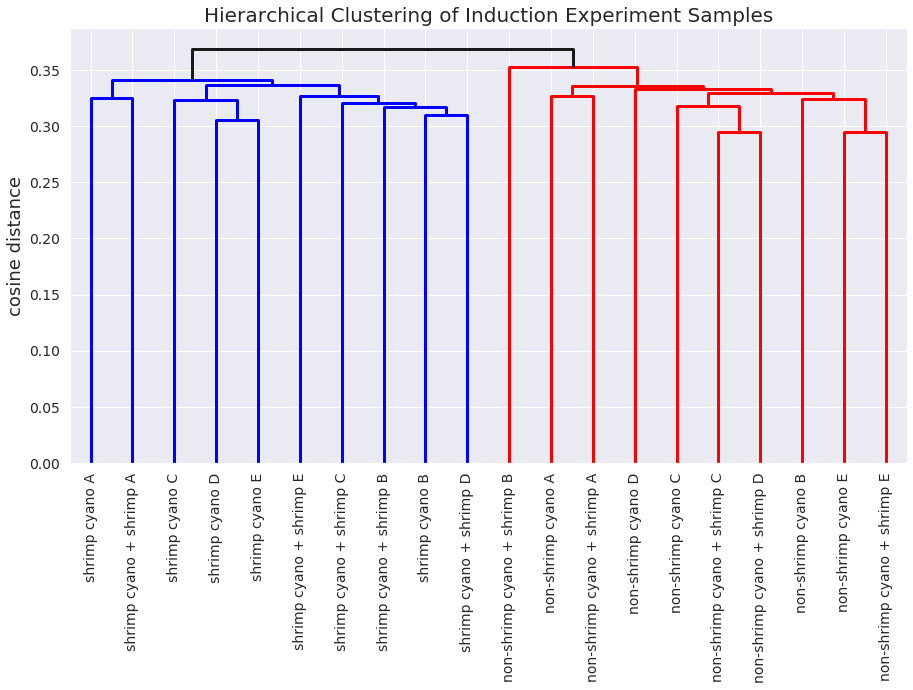

In [44]:
title = 'Hierarchical Clustering of Induction Experiment Samples'
sample_labels = 'name'
ref_for_labels = 'filename_path' #should be the column whose contents exactly match the sample names in df_transformed
metric = 'cosine'
method = 'average'
color_cutoff = 0.36
dataframe = df_transformed #usually df_transformed

#######################################################################################################################

dict_labels = pd.Series(md[sample_labels].values, index=md[ref_for_labels]).to_dict()
samplenames = [dict_labels[n] for n in dataframe]

#Clustering linkages followed by dendrogram construction
matplotlib.rcParams['lines.linewidth'] = 3
hc = linkage(dataframe.T, method, metric = metric)
plt.figure(figsize=(15,8))
plt.title(title, fontsize=20)
plt.ylabel(metric + ' distance', fontsize=18)
plt.yticks(fontsize=14)
dendrogram(
    hc,
    color_threshold=color_cutoff,
    above_threshold_color='k',
    leaf_rotation=90,
    leaf_font_size=14,
    labels = samplenames   
)
set_link_color_palette(['blue', 'red'])
plt.show()


### Cophenetic correlation
The cophenetic correlation coefficient is a measure of how well the linkages established in hierarchical clustering represent the actual calculated distances between pairs of samples. We can use it to judge how well a dendrogram represents to the underlying data.

In [ ]:
#Determining how well the dendrogram represents the cosine distances in the data
ccorr, distances = cophenet(hc, pdist(dataframe.T, metric))
ccorr

In [ ]:
# query for presence in selected group vs absences in rest
limit_category = 'ATTRIBUTE_collection_region'
limit = 'Guam'

category = 'ATTRIBUTE_collection_site'
interest = 'Finger Reef'

####################################################################
file_limit = [c for c in df_transformed.columns if c in md[md[limit_category] == limit]['filename'].values]
limited = df_transformed[file_limit]

files_of_interest = [c for c in limited.columns if c in md[md[category] == interest]['filename'].values]

df_transformed[np.max(limited.drop(files_of_interest, axis=1).T) <= 0].index
df_transformed[np.min(limited[files_of_interest].T) > 0].index

query_result = [r for r in limited[np.max(limited.drop(files_of_interest, axis=1).T) <= 0].index if r in limited[np.min(limited[files_of_interest].T) > 0].index]
query_result

In [ ]:
# limit/filter df
limit_category = 'ATTRIBUTE_collection_region'
limit = 'Guam'
dataframe = df_transformed

####################################################################
file_limit = [c for c in dataframe.columns if c in md[md[limit_category] == limit]['filename'].values]
limited = dataframe[file_limit]

In [ ]:
# query for presence in selected group vs absences in rest [length of regionally-specific core feats]
category = 'ATTRIBUTE_collection_region_GuamShrimp'
interest = 'Saipan'

####################################################################

files_of_interest = [c for c in df_transformed.columns if c in md[md[category] == interest]['filename'].values]

empty_feats = df_transformed[np.max(df_transformed.drop(files_of_interest, axis=1).T) <= 0].index
core_metab = df_transformed[np.min(df_transformed[files_of_interest].T) > 0].index

query_result = [r for r in core_metab if r in empty_feats]
len(query_result)

In [ ]:
# length of core feats per region/other category
category = 'ATTRIBUTE_collection_region_GuamShrimp'
interest = 'Paracel Islands'

####################################################################

files_of_interest = [c for c in df_transformed.columns if c in md[md[category] == interest]['filename'].values]

# df_transformed[np.max(df_transformed.drop(files_of_interest, axis=1).T) <= 0].index
len(df_transformed[np.min(df_transformed[files_of_interest].T) > 0].index)

# query_result = [r for r in df_transformed[np.max(df_transformed.drop(files_of_interest, axis=1).T) <= 0].index if r in df_transformed[np.min(df_transformed[files_of_interest].T) > 0].index]
# query_result

In [ ]:
np.sum(df_transformed['BB3_BB3_01_57129.mzXML'] > 0)

In [ ]:
# generate table with core, specific core, avg + sd of features per sample, # of samples; PER CATEGORY

category = 'ATTRIBUTE_collection_region_GuamShrimp'
cutoff = 1
dataframe = df_transformed

#############################################################################
core_summary_df = pd.DataFrame()
pd.options.display.float_format = "{:,.2f}".format

for cat in md[category].unique():
    files_of_interest = [c for c in dataframe.columns if c in md[md[category] == cat]['filename'].values]
    feats = [np.sum(dataframe[f] > 0) for f in files_of_interest]
    empty_feats = dataframe[np.max(dataframe.drop(files_of_interest, axis=1).T) <= 0].index
    core_metab = dataframe[np.sum(dataframe[files_of_interest].T > 0)/len(files_of_interest) >= cutoff].index
    query_result = [r for r in core_metab if r in empty_feats]

    core_summary_df[cat] = [np.mean(feats), np.std(feats), len(core_metab), len(query_result), len(files_of_interest)]
    
core_summary_df.drop(['na','unknown','Panama', 'Puerto Rico'], axis=1, inplace=True)
core_summary_df = core_summary_df.sort_index(axis=1)
core_summary_df.index = ['mean - feats/sample', 'std - feats/sample', 'core feats', 'specific core feats', 'sample size']
core_summary_df

In [ ]:
core_summary_df.to_csv('cores_summary_table_075.csv')

In [ ]:
# assembly dataframe of cores [all samples]
category = 'ATTRIBUTE_collection_region_GuamShrimp'
cutoff = 1
dataframe = df_transformed #usually df_transformed

#################################################################
all_core = []

for cat in md[category].unique():
    files_of_interest = [c for c in dataframe.columns if c in md[md[category] == cat]['filename'].values]
    core_metab = dataframe[np.sum(dataframe[files_of_interest].T > 0)/len(files_of_interest) >= cutoff].index
    all_core.extend(core_metab)
    
all_core = list(set(all_core))

cores = dataframe.loc[all_core]
cores

In [ ]:
# assembly dataframe of cores [by group]
category = 'ATTRIBUTE_collection_region_GuamShrimp'
cutoff = 0.75

#################################################################
all_core_df = pd.DataFrame()

for cat in md[category].unique():
    files_of_interest = [c for c in df_transformed.columns if c in md[md[category] == cat]['filename'].values]
    all_core_df[cat] = np.sum(df_transformed[files_of_interest].T > 0)/len(files_of_interest) >= cutoff

all_core_df.drop(['na','unknown','Panama', 'Puerto Rico'], axis=1, inplace=True)
#all_core_df = all_core_df[np.max(all_core_df.T) >= cutoff]
all_core_df = all_core_df[np.sum(all_core_df.sort_values(by='Papua New Guinea', ascending=False).T) > 0]

In [ ]:
sns.heatmap(all_core_df.sort_values(by='Paracel Islands', ascending=False), annot=False)

In [ ]:
hm_cores = pd.DataFrame(index = all_core_df.columns, columns = all_core_df.columns)
for col1 in all_core_df.columns:
    for col2 in all_core_df.columns:
        shared_core = len([m for m in all_core_df[all_core_df[col1]].index if m in all_core_df[all_core_df[col2]].index])
        hm_cores.at[col1, col2] = shared_core

hm_cores = hm_cores.sort_index(axis=0)        
hm_cores = hm_cores.sort_index(axis=1)
hm_cores_prop = hm_cores/np.max(hm_cores)
hm_cores_prop = hm_cores_prop.astype(float)

In [ ]:
sns.heatmap(hm_cores_prop, annot=False)

In [ ]:
hm_cores.to_csv('pariwise_cores_075.csv')

In [ ]:
hm_cores_prop.to_csv('pairwise_cores_prop_075.csv')

## Rarefation and core-size tracking

In [ ]:
# rarefaction
category = 'ATTRIBUTE_collection_region_GuamShrimp'

#################################################################
rarefaction = pd.DataFrame()
labels = []
samples = []
feats = []

for cat in md[category].unique():
    print(cat)
    files_of_interest = [c for c in df_transformed.columns if c in md[md[category] == cat]['filename'].values]
    comps = []
    for n in range(1, len(files_of_interest)+1):
        comps.extend(list(itertools.combinations(files_of_interest, n)))

    for comp in comps:
        labels.append(cat) 
        samples.append(len(comp))
        feats.append(np.sum(np.sum(df_transformed[list(comp)].T > 0) > 0))
        
rarefaction['labels'] = labels
rarefaction['samples'] = samples
rarefaction['features'] = feats

In [ ]:
ax = sns.lineplot(x="samples", y="features",
             hue="labels",
             data=rarefaction, estimator='mean', ci='sd')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

In [ ]:
# core-size vs sampling
category = 'ATTRIBUTE_collection_region_GuamShrimp'
cutoff = 1

#################################################################
core_v_samp = pd.DataFrame()
labels = []
samples = []
feats = []


for cat in md[category].unique():
    print(cat)
    files_of_interest = [c for c in df_transformed.columns if c in md[md[category] == cat]['filename'].values]
    comps = []
    for n in range(1, len(files_of_interest)+1):
        comps.extend(list(itertools.combinations(files_of_interest, n)))

    for comp in comps:
        labels.append(cat) 
        samples.append(len(comp))
        feats.append(np.sum(np.sum(df_transformed[list(comp)].T > 0)/len(comp) >= cutoff))
        
core_v_samp['labels'] = labels
core_v_samp['samples'] = samples
core_v_samp['features'] = feats

In [ ]:
ax = sns.lineplot(x="samples", y="features", hue="labels",
             data=core_v_samp, estimator='mean', ci='sd')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
#ax.set_ylim(0,800)
#ax.set_xlim(1,5)

In [ ]:
# core per mean samps
category = 'ATTRIBUTE_collection_region_GuamShrimp'
cutoff = 1

#################################################################
core_v_samp = pd.DataFrame()
labels = []
samples = []
feats = []
core_vals = []
props = []

for cat in md[category].unique():
    print(cat)
    files_of_interest = [c for c in df_transformed.columns if c in md[md[category] == cat]['filename'].values]
    comps = []
    for n in range(1, len(files_of_interest)+1):
        comps.extend(list(itertools.combinations(files_of_interest, n)))

    for comp in comps:
        labels.append(cat) 
        samples.append(len(comp))
        feats.append(np.sum(np.sum(df_transformed[list(comp)].T > 0) > 0))
        core_vals.append(np.sum(np.sum(df_transformed[list(comp)].T > 0)/len(comp) >= cutoff))
        props.append(np.sum(np.sum(df_transformed[list(comp)].T > 0)/len(comp) >= cutoff)/np.sum(np.sum(df_transformed[list(comp)].T > 0) > 0))
        
core_v_samp['labels'] = labels
core_v_samp['samples'] = samples
core_v_samp['features'] = feats
core_v_samp['core_va']
core_v_samp['proportion'] = props

In [ ]:
ax = sns.lineplot(x="samples", y="proportion", hue="labels",
             data=core_v_samp, estimator='mean', ci='sd')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

## Statistical Tests

In [ ]:
# generate pairwise values for cosine distance and number of shared features (prop?)
category = 'ATTRIBUTE_shrimp_v_nonshrimp'
dataframe = limited

########################################################
same_group = []
cos_dist = []
shared_feats = []
sf_prop = []

for pair in list(itertools.combinations(dataframe.columns, 2)):
    same_group.append(md[md['filename'] == pair[0]][category].values[0] == md[md['filename'] == pair[1]][category].values[0])
    cos_dist.append(cosine(dataframe[pair[0]].values, dataframe[pair[1]].values))
    shared_feats.append(np.sum(np.sum(dataframe[[pair[0], pair[1]]].T > 0) == 2))
    sf_prop.append(np.sum(np.sum(dataframe[[pair[0], pair[1]]].T > 0) == 2)/np.min(np.sum(dataframe[[pair[0], pair[1]]] > 0).values))

stats_test = pd.DataFrame(index = same_group)
stats_test['cos_dist'] = cos_dist
stats_test['shared_feats'] = shared_feats
stats_test['sf_prop'] = sf_prop

stats_test
                                  


In [ ]:
3.7757/2





In [ ]:
# t-test to test if distributions of cosine distance and shared core features differ\
## between two populations (same label vs different label)
measure = 'sf_prop'


ttest_ind(stats_test.loc[True][measure], stats_test.loc[False][measure], equal_var=False)


### Hierarchical clustering - tabular output
In some instances, it may be useful to have a tabular output of the hierarchical clustering that is visualized via dendrogram above. Generate such a table by running the cell below.

In [ ]:
#Table output of hierarchical clustering
hc_df = pd.DataFrame(hc)
hc_df.columns = ['cluster 1', 'cluster 2', 'distance at merge', 'number of samples in new cluster']
hc_df['new cluster number'] = [c for c in range(len(list(df_transformed.T.index)),len(list(df_transformed.T.index))+len(hc_df))]

c1_alias = []
for c in hc_df['cluster 1']:
    if c < len(list(df_transformed.T.index)):
        c1_alias.append(list(df_transformed.T.index)[int(c)])
    else:
        c1_alias.append('none')
        
c2_alias = []
for c in hc_df['cluster 2']:
    if c < len(list(df_transformed.T.index)):
        c2_alias.append(list(df_transformed.T.index)[int(c)])
    else:
        c2_alias.append('none')


hc_df['cluster 1 alias'] = c1_alias
hc_df['cluster 2 alias'] = c2_alias
hc_df

### Pairwise distance matrix
In some instances, it may also be useful to generate a pairwise distance matrix for the samples in the bucket table. Do so by running the cell below. Note: This will use the same distance metric as specified above in the hierarchical clustering parameters.

In [ ]:
pairwise = pd.DataFrame(squareform(pdist(df_transformed.T, metric)))
pairwise.index = df_transformed.T.index
pairwise.columns = df_transformed.T.index
pairwise

## Feature Selection + Heat Map

### Feature selection
For feature selection, ORCA uses univariate feature selection, as implemented in sklearn (https://scikit-learn.org/stable/). Univariate feature selection was selected as the optimal strategy of feature selection for this particular problem (e.g. identifying the most important features in driving clustering of different groups of samples) as it considers features individually and so is not negatively impacted by correlated features. In order to truly judge the statistical significance of features, univariate feature selection must be applied to a dataset with proper numbers of replicates per category of sample, and must also meet the three assumptions necessary for applying the ANOVA statistical test (here is a good resource for reviewing those assumptions: https://sites.ualberta.ca/~lkgray/uploads/7/3/6/2/7362679/slides_-_anova_assumptions.pdf) Even in cased where the assumptions are not met, or there are not enough replicate samples per category, feature selection can still be helpful for generating hypotheses about which features may be significant. To conduct univariate feature selection, please set the below parameters:

**sample_labels**: Input the column name from the metadata table that you would like samples to be grouped by.

**ref_for_labels**: This should be the column name whose contents exactly match the sample names in df_transformed. This will allow the sample (grouping) labels to be properly mapped to the samples.

**top_k**: Number of top features to display.

**rank_by**: Column to rank results by. This could be 'p-value' or 'F-values', if the goal is to see the most statistically significant features, as determined by univariate feature selection. 

**ascending**: Setting this variable to 'True' will list values from the designated column (as indicated with the 'rank_by' variable) from smallest to largest, while setting it to 'False' will list the values from largest to smallest.



In [ ]:
sample_labels = 'location'
ref_for_labels = 'filename_path' #should be the column whose contents exactly match the sample names in df_transformed

top_k = 5
rank_by = 'Saipan'
ascending = False

#######################################################################################################################

dict_labels = pd.Series(md[sample_labels].values, index=md[ref_for_labels]).to_dict()
samplenames = [dict_labels[n] for n in df_transformed]

df_featselect = df_transformed.copy(deep = True)
df_featselect.index = list(df_transformed.index)

F_values, p_values = sklearn.feature_selection.f_classif(df_featselect.T.values,samplenames)
feat_select_results = pd.DataFrame(index = list(df_transformed.index))
feat_select_results['F-values'] = F_values
feat_select_results['p-values'] = p_values

group_means = df_featselect.T.groupby(md['location'].values).agg('mean').T

fs = pd.concat([feat_select_results, group_means], axis = 1).sort_values(by = rank_by, ascending=ascending).head(top_k)
fs




### Heat map visualizations
Heat maps can be generated for the feature selection output, or for an excerpt of the features vs samples bucket table.

**feat_select_or_bucket_table**: Indicate either 'feat_select' or 'bucket_table', depending on which you would like a heat map generated of.

If you select 'bucket_table', you can also indicate an m/z range for which features you would like included.

**mz_high**: Upper limit of m/z for inclusion in the heat map

**mz_low**: Lower limit of m/z for inclusion in the heat map

In [ ]:
feat_select_or_bucket_table = 'bucket_table'
mz_high = 460
mz_low = 450

##################################################################################################################

if feat_select_or_bucket_table == 'feat_select':
    ax = sns.heatmap(fs.drop(['p-values', 'F-values'], axis=1))
elif feat_select_or_bucket_table == 'bucket_table':
    ax = sns.heatmap(df_transformed.query('mz > @mz_low and mz < @mz_high'))
else:
    print('invalid input. Try "feat_select" or "bucket_table".')
    

## Tentative Identification of Features

While m/z of an MS1 feature is not enough information to confidently identify what compound is in a sample, cross referencing features with lists of known compounds can allow for quick dereplication, which is very helfpul in the context of natural products discovery. The cell below allows one to load in a table of known compounds, their masses, and expected m/z for protenated and sodiated peaks, and then annotate features in your dataset based on this set of known compounds. By default, features are ordered based on which are the most prominent (e.g. which features have the largest values).

The parameters to set are:

**mz_tolerance**: How close a feature's m/z must be to the protenated or sodiated m/z of a known compound in order for the feature to be annotated as that known compound.

**top_k**: Number of features to output. Note: features are ranked by greattest value to smallest value, as determined by selecting the max value for a feature across all samples.

**db_path**: Path to table of known compounds to be used for annotation. Table must be a csv file with at least three columns: 'Name', 'Protenated Peak', and 'Sodiated Peak'.

In [ ]:
mz_tolerance = 1
top_k = 10
db_path = './Moorea_bouillonii_db.csv'


######################################################################################################################

db = pd.read_csv(db_path)

df_top = df_transformed.T.max().sort_values(ascending=False).head(top_k).reset_index()

df_top.columns = ['mz', 'rt', 'max transformed integral']

column_pids = []
column_difs = []
for m in df_top['mz']:
    putative_ids = []
    difs = []
    for i in db.index:
        if abs(m - db.iloc[i]['Protenated Peak']) <= mz_tolerance:
            putative_ids.append(db.iloc[i]['Name'] + ' [M+H]+')
            difs.append(round(abs(m - db.iloc[i]['Protenated Peak']),2))
    for i in db.index:
        if abs(m - db.iloc[i]['Sodiated Peak']) <= mz_tolerance:
            putative_ids.append(db.iloc[i]['Name'] + ' [M+Na]+')
            difs.append(round(abs(m - db.iloc[i]['Sodiated Peak']),2))
    if len(putative_ids) == 0:
        putative_ids.append('None')
        difs.append(0)
    column_pids.append(putative_ids)
    column_difs.append(difs)
    
df_top['putative ids'] = column_pids
df_top['difference'] = column_difs
df_top

# Miscellaneous 
Here are some bits of code that might be useful. Feel free to add your own!

In [ ]:
#number of features per sample, post transformations
df_transformed[df_transformed > 0].count()

In [ ]:
# export a dataframe to csv
df_transformed.to_csv('bucket_table-transformed.csv')